In [31]:
import numpy as np
import mpnum as mp
import matplotlib.pyplot as pl
from maxlike import MlEstimator, qubit_linear_cluster
from mpnum.povm  import MPPovm, pauli_povm
from tqdm import tqdm

from IPython import display

In [2]:
%load_ext autoreload
%autoreload 2

In [158]:
N_QUBITS = 6
R = 3
epsilon = 0.1
maximally_mixed = mp.eye(N_QUBITS, 2)
maximally_mixed /= mp.trace(maximally_mixed)

psi_0 = qubit_linear_cluster(N_QUBITS)
rho_0 = (1 - epsilon) * mp.mpsmpo.mps_to_mpo(psi_0)
rho_0 += epsilon * maximally_mixed
norm = mp.norm(rho_0)
overlap = rho_0.compress(rank=5)
rho_0.ranks, overlap / (mp.norm(rho_0) * norm)

((4, 5, 5, 5, 4), 1.0000000000000002)

In [159]:
local_pauli = pauli_povm(dim=2)
povm = MPPovm.from_local_povm(local_pauli, width=R)
expvals = [y.to_array() for y in povm.expectations(rho_0, mode='mpdo')]

In [160]:
mle = MlEstimator(N_QUBITS, 2, povm, prop_compr_args={})
R, _ = mle.propagator(rho_0, expvals)

In [163]:
R.ranks

AttributeError: 'MPArray' object has no attribute 'rank'

0.00099929872484192978

0.210345955733


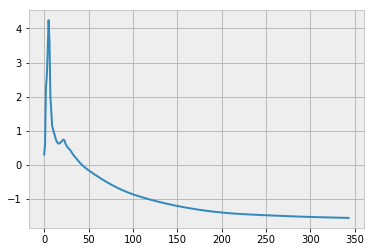

In [162]:
def solve_mpo(mle, expvals, dist, compr_args={}):
    rho_init = mp.random_mpdo(N_QUBITS, ldim=2, rank=1)
    it = mle._iterative_solution(expvals, rho_init, compr_args=compr_args)
    rho_last = rho_init
    for rho, loglike in it:
        yield rho, loglike
        normdist = mp.normdist(rho, rho_last)
        display.clear_output(wait=True)
        display.display(normdist)
        if normdist < dist:
            return
        rho_last = rho

mle = MlEstimator(N_QUBITS, 2, povm, prop_compr_args={'rank': 10})
solution = list(solve_mpo(mle, expvals, 1e-3, compr_args={'rank': 7}))
print(mp.normdist(solution[-1][0], rho_0))
pl.plot([np.log(mp.normdist(rho, rho_0)) for rho, _ in solution]) 

In [114]:
nonhermicity = lambda x: mp.normdist(x, x.adj())

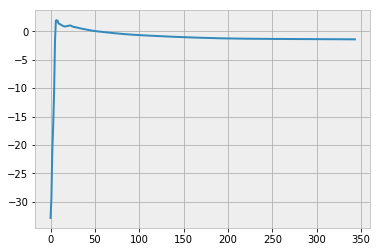

In [164]:
pl.plot([np.log(nonhermicity(rho)) for rho, _ in solution])

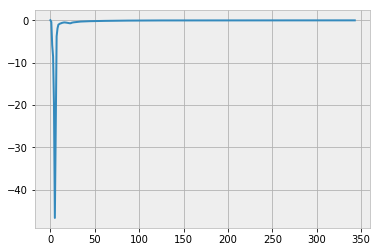

In [165]:
from mpnum.utils.array_transforms import local_to_global

def eigvals(rho):
    x = 1 / 2 * (rho + rho.adj()).to_array_global()
    x_dim = np.prod([p for p, _ in rho.shape])
    x = x.reshape((x_dim, x_dim))
    return np.linalg.eigvalsh(x)

pl.plot([min(eigvals(rho)) for rho, _ in solution])

9.9902629033341982e-06

0.149853243309


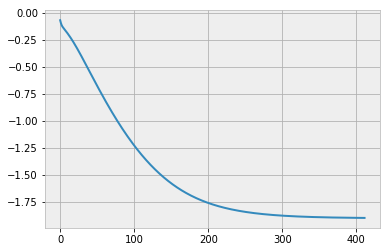

In [170]:
def solve_pmps(mle, expvals, dist, compr_args={}):
    psi_init = mp.random_mpo(N_QUBITS, 2, rank=1)
    #psi_init = mp.mpsmpo.mps_to_pmps(mp.random_mps(N_QUBITS, 2, 1))
    it = mle._iterative_solution_pmps(expvals, psi_init, compr_args=compr_args)
    rho_last = mp.mpsmpo.pmps_to_mpo(psi_init)
    for psi, loglike in it:
        yield psi, loglike
        rho = mp.mpsmpo.pmps_to_mpo(psi)
        normdist = mp.normdist(rho, rho_last)
        display.clear_output(wait=True)
        display.display(normdist)
        if normdist < dist:
            return
        rho_last = rho

mle = MlEstimator(N_QUBITS, 2, povm, prop_compr_args={'rank': 10})
solution = list(solve_pmps(mle, expvals, 1e-5, compr_args={'rank': 6}))
print(mp.normdist(mp.mpsmpo.pmps_to_mpo(solution[-1][0]), rho_0))
pl.plot([np.log(mp.normdist(mp.mpsmpo.pmps_to_mpo(psi), rho_0)) for psi, _ in solution]) 

In [78]:
mp.mpsmpo.mps_to_pmps(mp.random_mps(N_QUBITS, 2, 1)).shape

((2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1))